# 8.뉴스 요약봇 만들기
## 프로젝트: 뉴스기사 요약해보기 
* 추상적 요약과 추출적 요약 모두 해보기

In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

## Step 1. 데이터 수집하기
* 뉴스 기사 데이터(news_summary_more.csv)를 사용
* https://github.com/sunnysai12345/News_Summary

In [2]:
#  데이터 다운로드

import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [3]:
data.sample(10)

,headlines,text
35759,Sri Lanka Prez suspends Parliament amid politi...,Sri Lanka President Maithripala Sirisena on Th...
57406,Viral rejection letter from 1928 calls author'...,A rejection letter by Australian publisher Ang...
29665,Users complain of getting WhatsApp texts from ...,Several users have claimed that they are recei...
11782,We've other priorities: SC on UP's plea for ur...,Turning down Uttar Pradesh government's reques...
90491,Umpires offered apples before IPL match at Ede...,In Wednesday's IPL match between Kolkata Knigh...
30246,GQ magazine cover features extra photoshopped ...,In a dig at the alleged photoshopped cover of ...
46327,Mithali hits more than two 6s for 1st time in ...,Indian woman cricketer Mithali Raj smashed mor...
93427,Severed head of calf recovered from Allahabad ...,Tension prevailed in Teliarganj area of Allaha...
69039,Number of GST returns filed highest on last da...,As many as 13.76 lakh businesses used the GSTN...
18476,Twitter 'unfairly' reduced 6 lakh accounts' vi...,Twitter Co-founder and CEO Jack Dorsey on Wedn...


* 이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성

* 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있음.
* 추출적 요약을 하는 경우에는 오직 text열만을 사용.

## Step 2. 데이터 전처리하기 (추상적 요약)
* 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보자.
* 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보자.

In [4]:
import nltk    # NLTK 패키지에서 불용어 사전을 다운로드
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

=3


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
data.head()    # 5개만 출력

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [6]:
data = data[['text','headlines']] # 훈련에 사용할 headlines 열과 text 열만 별도 저장&출력
                                 # text 열의 내용을 요약한 것이 headlines 열
data.head()

,text,headlines
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."


### 2-1. (1) 데이터 정리
#### 중복 샘플 제거

In [7]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [8]:
data.drop_duplicates(subset = ['text'], inplace=True)  # drop_duplicates() : 중복 샘플을 제거
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [9]:
print(data.isnull().sum())  # Null 값이 있는지 확인

text         0
headlines    0
dtype: int64


#### 텍스트 정규화

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### 불용어 제거

In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [12]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


* NLTK를 이용해 불용어를 제거하는 파트 : text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 headlines 전처리할 때는 호출하지 않을 예정.
* Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 headlines 남아 있는 게 더 좋을 것 같음.
→ remove_stopwords 추가, if문 추가

In [13]:
# 전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 headlines를 만들어 함수를 호출
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


* 모든 알파벳이 소문자로 변환
* \<br />과 같은 html 태그가 제거
* (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거
* 특수문자가 제거(영어만 남음.)

#### 훈련 데이터 전체에 대해서 전처리

* Text의 경우에는 불용어를 제거
* headlines의 경우에는 불용어를 제거하지 않을 것
= 따로 호출해서 진행

In [15]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [16]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [17]:
# 데이터프레임에 재저장
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [18]:
data.isnull().sum()  # .isnull().sum()을 사용해서 Null 값 확인

text         0
headlines    0
dtype: int64

In [19]:
# 정제 과정에서 모든 단어가 제거되어 생성된 70개의 빈 샘플 제거 
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 2-1. (2) 훈련데이터와 테스트데이터 나누기
#### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


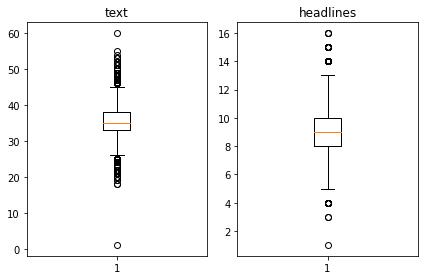

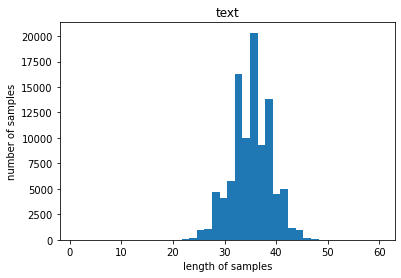

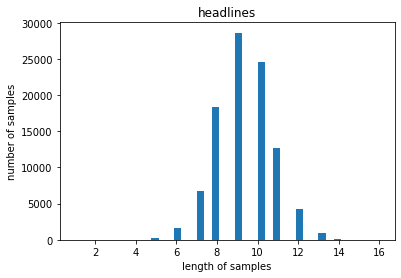

In [20]:
# 훈련에 사용할 샘플의 최대 길이 지정

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

(위에서부터 차례대로 그래프)
* 실제 텍스트와 요약의 길이 분포
* 실제 텍스트 샘플 길이별 개수
* 요약본 샘플 길이별 개수

* text의 경우 최소 길이가 1, 최대 길이가 60.
* 평균 길이는 35로 시각화된 그래프로 봤을 때는 대체적으로는 20~ 50의 길이를 가진다는 것을 확인.

* headlines의 경우 최소 길이가 1, 최대 길이가 16, 평균 길이가 9로 text에 비해 상대적으로 길이가 매우 짧음.
* 그래프로 봤을 때에도 대체적으로 4~14의 길이를 가짐.

In [21]:
# Text와 headlines의 적절한 최대 길이를 임의로 지정

text_max_len = 60
headlines_max_len = 12
print('=3')

=3


In [22]:
# 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [23]:
# 임의의 길이가 몇%의 샘플까지 포함하는지 확인

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


* 각각 60과 10로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 됨.
* text열과 headlines열 모두 98% 이상 해당 길이로 패딩됨.

In [24]:
# 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 97183


#### 시작 토큰과 종료 토큰 추가하기
* 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가

* decoder_input : 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름
* decoder_target : 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름

In [25]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,text,headlines,decoder_input,decoder_target
0,saurav kant alumnus upgrad iiit pg program mac...,upgrad learner switches to career in ml al wit...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [26]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


#### 훈련 데이터와 테스트 데이터 분리

In [27]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[38200 20916 89301 ... 84595 61261  3039]


In [28]:
# 데이터의 샘플 순서를 정의(:잘 섞인 샘플)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [29]:
# 테스트 데이터의 크기를 정의

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19436


In [30]:
# 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분 (:표시의 위치 주의)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77747
훈련 레이블의 개수 : 77747
테스트 데이터의 개수 : 19436
테스트 레이블의 개수 : 19436


### (3) 정수 인코딩
#### 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [31]:
# 입력된 훈련 데이터로부터 단어 집합 생성

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


* 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여
* 빈도수가 낮은 단어들은 훈련 데이터에서 제외

In [32]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():  # 단어와 각 단어의 등장 빈도수가 저장돼 있음
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69309
등장 빈도가 6번 이하인 희귀 단어의 수: 47249
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22060
단어 집합에서 희귀 단어의 비율: 68.17152173599388
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.513971179816199


* 등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 65% 이상을 차지.
* 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.5%.

* 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거.
* 위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 22,000으로 제한.

In [33]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [34]:
# 텍스트 시퀀스를 정수 시퀀스로 변환 : texts_to_sequences()
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[78, 5671, 6358, 186, 4, 424, 4628, 2000, 308, 71, 785, 482, 105, 424, 308, 17, 78, 201, 533, 4628, 701, 471, 201, 533, 1326, 90, 23], [78, 1952, 1341, 628, 82, 2694, 221, 761, 1553, 112, 276, 14737, 10, 35, 3821, 127, 457, 590, 1281, 5490, 14237, 1062, 35, 315, 2481, 4], [2105, 7, 70, 2640, 102, 283, 19432, 22, 1342, 25, 70, 450, 363, 121, 256, 893, 497, 3862, 1651, 70, 102, 301, 51, 426, 70, 1651, 283, 19432, 275, 619, 210, 1095, 2137, 314, 12870, 1249, 3504, 298]]


In [35]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)  #  전체 단어 집합과 각 단어에 대한 빈도수를 계산
print('=3')

=3


In [36]:
# 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29955
등장 빈도가 5번 이하인 희귀 단어의 수: 19563
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10392
단어 집합에서 희귀 단어의 비율: 65.30796194291437
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.685610033978609


* 등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 65%를 차지.
* 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 4.7%.
* 아까 했던 것과 동일하게 이 단어들은 모두 제거.
*  어림잡아 10,000을 단어 집합의 크기로 제한.

In [37]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 117, 478, 1713, 2871, 7, 4971, 386, 7608, 3, 327], [1, 263, 13, 1353, 1944, 15, 159, 1317], [1, 1166, 36, 188, 2026, 72, 155, 188], [1, 2248, 4972, 385, 6, 1196, 8, 43, 36, 1945, 922], [1, 140, 372, 18, 2663, 1022, 7, 4509, 16, 1092, 201]]
target
decoder  [[117, 478, 1713, 2871, 7, 4971, 386, 7608, 3, 327, 2], [263, 13, 1353, 1944, 15, 159, 1317, 2], [1166, 36, 188, 2026, 72, 155, 188, 2], [2248, 4972, 385, 6, 1196, 8, 43, 36, 1945, 922, 2], [140, 372, 18, 2663, 1022, 7, 4509, 16, 1092, 201, 2]]


* 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성.
* 이 현상은 길이가 상대적으로 길었던 원문(text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 9밖에 되지 않았던 요약문(headlines)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높음.

In [38]:
# 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 5인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 5]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 5]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 354
삭제할 테스트 데이터의 개수 : 87
훈련 데이터의 개수 : 77393
훈련 레이블의 개수 : 77393
테스트 데이터의 개수 : 19349
테스트 레이블의 개수 : 19349


* 훈련 데이터와 테스트 데이터 모두 일정량의 샘플들이 제거된 것을 확인

#### 패딩하기
* 정해둔 최대 길이로 패딩.
* 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춤.

In [39]:
# 같은 길이로 맞춰주는 패딩 작업

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


### 2-1. (2) 모델 설계하기
#### 함수형 API를 이용해서 인코더 설계

In [40]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

* 임베딩 벡터의 차원은 128로 정의, hidden state의 크기를 256으로 정의.
* hidden state : LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터.
  (이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해)
* 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아님.

* 인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높임. (hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있음)

#### 디코더 설계

In [41]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

* 디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일.
* 하지만, LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 함.

#### 디코더 출력층 설계

In [42]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')  # 다중 클래스 분류 문제
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

* 지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq.
* 그런데, 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법으로 어텐션 메커니즘을 사용.

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
* 일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있음.
* 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보자.

In [43]:
# 어텐션 층 생성, 위에서 설계한 디코더 출력층수정

from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

* 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용.
* 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동.

### 2-1. (3) 모델 훈련하기
* 설계한 모델을 가지고 훈련을 진행.

In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
303/303 [==============================] - 350s 1s/step - loss: 5.6321 - val_loss: 5.1693
Epoch 2/50
303/303 [==============================] - 338s 1s/step - loss: 5.0296 - val_loss: 4.8473
Epoch 3/50
303/303 [==============================] - 337s 1s/step - loss: 4.7178 - val_loss: 4.5907
Epoch 4/50
303/303 [==============================] - 337s 1s/step - loss: 4.4638 - val_loss: 4.4007
Epoch 5/50
303/303 [==============================] - 338s 1s/step - loss: 4.2558 - val_loss: 4.2638
Epoch 6/50
303/303 [==============================] - 336s 1s/step - loss: 4.0841 - val_loss: 4.1224
Epoch 7/50
303/303 [==============================] - 339s 1s/step - loss: 3.9385 - val_loss: 4.0437
Epoch 8/50
303/303 [==============================] - 339s 1s/step - loss: 3.8151 - val_loss: 3.9649
Epoch 9/50
303/303 [==============================] - 249s 820ms/step - loss: 3.7085 - val_loss: 3.9148
Epoch 10/50
303/303 [==============================] - 238s 785ms/step - loss: 3.6116 - 

#### 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화

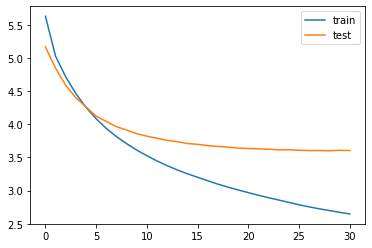

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 2-1. (4) 인퍼런스 모델 구현하기
* 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비

In [46]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


* seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 함.

* 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비.

* 그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 함.

In [47]:
# 인코더 모델과 디코더 모델을 분리해서 설계

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [48]:
# 어텐션 메커니즘을 사용하는 출력층을 설계

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [49]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 생성

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
* 원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보자.


* 테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편리.
* 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 생성.
  (함수를 만들 때, text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외, headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외)

In [50]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [51]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : communist party india monday urged centre clarify reports national security advisor ajit doval attended bjp meeting upcoming state elections union minister rajnath singh residence alleging shocking violation rules party questioned senior government functionary like nsa could attend political party meeting 
실제 요약 : cpi slams nsa doval for allegedly attending bjp meet 
예측 요약 :  govt denies reports of india defence minister resigns


원문 : chinese students paid special tribute mahatma gandhi birth anniversary beijing gandhi statue park ceremony park students read several well known teachings gandhiji indian embassy music teachers sang notably china centre indian studies shanghai university 
실제 요약 : chinese students pay tribute to gandhiji in beijing 
예측 요약 :  chinese girls make chinese temple rahul gandhi statue


원문 : retired undefeated boxer floyd mayweather bugatti put sale ebay million luxury car mayweather sold car luxury auto collection looking sell grand sport models worldwide 

### 성능개선 방안
* seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정
* 빔 서치(beam search)
* 사전 훈련된 워드 임베딩(pre-trained word embedding)
* 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)

## Step 5. Summa을 이용해서 추출적 요약해보기
* 추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높음.
* 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮음.
* Summa의 summarize를 사용하여 추출적 요약을 해보자.
(패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습 해볼 수 있음.)

In [52]:
import requests
from summa.summarizer import summarize

In [53]:
text = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print(text[:1500])

                                              headlines  \
0     upGrad learner switches to career in ML & Al w...   
1     Delhi techie wins free food from Swiggy for on...   
2     New Zealand end Rohit Sharma-led India's 12-ma...   
3     Aegon life iTerm insurance plan helps customer...   
4     Have known Hirani for yrs, what if MeToo claim...   
...                                                 ...   
1495  Have seen Sachin Tendulkar get angry but not M...   
1496  Player ensures wife stays dry in rain during A...   
1497  Federer denied entry into locker room by secur...   
1498  42/42 seats in West Bengal: CM Mamata's cutout...   
1499  Court refuses chargesheet by Delhi Police agai...   

                                                   text  
0     Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1     Kunal Shah's credit card bill payment platform...  
2     New Zealand defeated India by 8 wickets in the...  
3     With Aegon Life iTerm Insurance plan, customer...  
4

#### summarize 사용하기

Summa의 summarize()의 인자로 사용되는 값

* text (str) : 요약할 테스트.
* ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
* words (int or None, optional) – 출력에 포함할 단어 수.
* 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
* split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize
* 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행.
* 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있음.
* 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여봄.
* 원문의 0.005%만을 출력하도록 설정.

In [61]:
print('headlines:')
print(summarize(text["text"][i], ratio=0.5))

headlines:
He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector".


In [62]:
# 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True

print('headlines:')
print(summarize(text["text"][i], ratio=0.5, split=True))

headlines:
['He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector".']


In [63]:
# 단어의 수로 요약문의 크기를 조절가능. (단어를 50개만 선택)

print('headlines:')
print(summarize(text["text"][i], words=50))

headlines:
Prime Minister Narendra Modi on Wednesday said his government's demonetisation decision made houses affordable for the aspiring youth.
He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector".


## 루브릭

### 프로젝트 개인평가

#### 1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
##### 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.



#### 2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
##### 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.



#### 3. Extractive(추출적) 요약을 시도해 보고 Abstractive(추상적) 요약 결과와 함께 비교해 보았다.
##### 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.




## 회고
다른 것 보다 모델 훈련 시간이 너무 오래걸려서 진도가 잘 안나가는 프로젝트였다.
다양한 시도를 해보고 싶어도 모델 훈련 시간이 너무 오래걸려서 시도할 수 없었다.ㅠㅠ

Extractive(추출적) 요약에 있어서 ratio=0.005, ratio=0.05 에서는 요약문이 출력되지 않았다. ratio=0.5가 되서야 요약문이 출력되었다. (ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값)
ratio의 소수점 값 변화에 따라 출력 여부를 확인 할 수 있었다.

Extractive(추출적) 요약과  Abstractive(추상적) 요약 결과로 요약 문장을 얻어 번역기를 돌려 보았더니 문맥상으로는 Abstractive(추상적) 요약이 한결 부드럽게 연결되었다.
그렇지만 내용 이해에 있어서 본문의 내용을 정확히 요약한 것인지는 의문이다.

프로젝트를 진행한 데이터의 원문 자체가 lms 노드에 비해 짧은 편이여서 그런지 문맥이나 내용 이해에 있어서는 핵심 단어나 문장을 그대로 가져오는 Extractive(추출적) 요약이 적합하다고 생각된다.

원문이 길 경우 충분히 모델 학습이 됐다는 전제로 Abstractive(추상적) 요약이 유리할 것 같고, 원문이 짧은 경우에는 Extractive(추출적) 요약이 유리해 보인다.